In [23]:
from pylab import imshow, figure, plot, colorbar, show, hist
%matplotlib inline

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'


In [9]:
import data
import datagen
import net
import scipy.ndimage.interpolation
import numpy as np
import pandas as pd
import pickle

In [5]:
def ndsb17_get_predicted_nodules_v2(vsize, patient_ids, min_activity=30):
    X_predicted_nodules = []
    for pid in patient_ids:
        try:
            with open('/mnt/data/ndsb17/predict/boxes/' + pid + '.pkl', 'rb') as fh:
                label_boxes, label_sizes, label_activities_sum, label_activities_max = pickle.load( fh )
        except FileNotFoundError as e:
            print(pid, str(e))
            X_predicted_nodules.append(None)
            continue

        idx = np.argsort(label_activities_sum)[::-1][:1]
        box = label_boxes[idx]
        if box is None:
            print(pid, 'no areas')
            X_predicted_nodules.append(None)
            continue
        if label_activities_sum[idx] < min_activity: # TODO soft threshold
            print(pid, 'no areas with high enough activity', label_activities_sum[idx])
            X_predicted_nodules.append(None)
            continue
        
        center = 2*np.asarray([(box[0].start+box[0].stop)//2, (box[1].start+box[1].stop)//2, (box[2].start+box[2].stop)//2 ])
        diam = 2*np.mean([(box[0].start-box[0].stop), (box[1].start-box[1].stop), (box[2].start-box[2].stop) ])

        image = data.ndsb17_get_image(pid)
        #segmented_image = ndsb17_get_segmented_image(pid)

        pos = center - vsize//2
        volume = image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2] ]
        #segmented_volume = segmented_image[pos[0]:pos[0]+vsize[0], pos[1]:pos[1]+vsize[1], pos[2]:pos[2]+vsize[2] ]
        if volume.shape != (64,64,64):
            print(pid, 'shape mismatch')
            X_predicted_nodules.append(None)
            continue # TODO report something
        #volume = (volume + 1000)*segmented_volume - 1000
        X_predicted_nodules.append(volume)

    return X_predicted_nodules


In [112]:
import data
import datagen
import net
import scipy.ndimage.interpolation
import numpy as np
import pandas as pd
import pickle

df = data.ndsb17_get_df_test_labels()

vsize64 = np.asarray((64,64,64))

patient_ids = df["id"].tolist()

X_nodules = ndsb17_get_predicted_nodules_v2(vsize64, patient_ids, min_activity=10)

p_base = len(df[df["cancer"]==1]) / len(df)

y_true, y_pred = [], []
for n in range(len(df)):
    pid = df["id"][n]
    #print(pid, df["cancer"][n])
    y_true.append(df["cancer"][n])

y_true = np.asarray(y_true)

06a90409e4fcea3e634748b967993531 no areas with high enough activity [ 8.77979207]
0b20184e0cd497028bdd155d9fb42dc9 no areas with high enough activity [ 4.20381451]
1753250dab5fc81bab8280df13309733 no areas with high enough activity [ 6.62632084]
38bf066bba822584e14c0af65d4bb5e9 shape mismatch
3ee1fd6a0f3f108c3558e6699fb011f2 no areas with high enough activity [ 6.37045431]
4b28f147cb82baba3edcdbd34ca19085 no areas
50cdacec399071cf70d8badd2511d0b3 no areas with high enough activity [ 2.34735084]
519ad4ead3e61d2d71088ac8e46f25b6 shape mismatch
70f4eb8201e3155cc3e399f0ff09c5ef shape mismatch
80938b4f531fa2334c13d829339e1356 no areas with high enough activity [ 2.12381816]
85d6fb4a08853d370935a75de7495a27 no areas with high enough activity [ 4.55358553]
94df6d1ae21c5bfaebe6f8daf8fcd85b shape mismatch
9cc74e673ec9807ee055973e1b185624 shape mismatch
a334d15ac8d2d25bce76693b1b2a3ed7 shape mismatch
ae2fdcd8daa3fede6ae23cc63a8d9a82 no areas with high enough activity [ 2.19259]
aec5a58fea38b77b9

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


In [119]:
for n in range(len(X_nodules)):
    if X_nodules[n] is None:
        X_nodules[n] = np.zeros((64,64,64)) - 1000

X_nodules = np.stack(X_nodules)[:,16:16+32,16:16+32,16:16+32,None]
X_nodules = datagen.preprocess(X_nodules)
X_nodules = scipy.ndimage.interpolation.zoom(X_nodules, (1, 0.5, 0.5, 0.5, 1), order=1)


/home/alex/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:571: RuntimeWarning: invalid value encountered in true_divide
  zoom = (numpy.array(input.shape) - 1) / zoom_div


In [120]:
import importlib
import net

config_name = 'config_baseline2'
config = importlib.import_module(config_name)
model = net.model3d((16, 16, 16), sz=config.feature_sz, alpha=config.feature_alpha)
model.load_weights('/mnt/data/snap/config_baseline2__20170401054549.0023.h5')

In [121]:
y_pred = model.predict(X_nodules, batch_size=1)[:,1]

In [122]:
c = [y_pred[n] for n in range(len(y_pred)) if y_true[n] == 1]
nc = [y_pred[n] for n in range(len(y_pred)) if y_true[n] == 0]

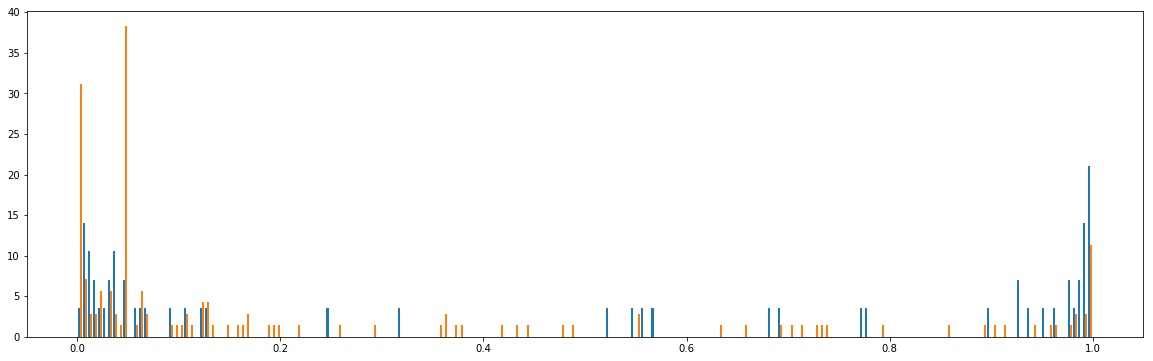

In [123]:
figure(figsize=(20,6))
h = hist((c,nc), range=(0,1), bins=200, normed=True)

In [ ]:
for n in range(len(y_pred)):
    if np.mean(X_nodules[n])

In [124]:
y_cal = np.zeros(y_true.shape)

def oddsr(a, b):
    return float(b) / (a+b)

for k in range(len(y_pred)):
    if y_pred[k] <= 0.005:
        y_cal[k] = oddsr(21, 3.5)
    elif y_pred[k] > 0.0475 and y_pred[k] < 0.0476:
        y_cal[k] = oddsr(75, 28)
    elif y_pred[k] > 0.95:
        y_cal[k] = oddsr(8.5+3+3+1.4+1.4, 21+14+7+3+7+3+3+3+3)
    else:
        y_cal[k] = oddsr(1, 1)

#y_cal *= p_base

In [76]:
# for k in range(len(y_pred)):
#     if y_pred[k] > 0.0475 and y_pred[k] < 0.0476:
#         y_pred[k] = 0


In [114]:
import sklearn.metrics

In [125]:
sklearn.metrics.log_loss(y_true, y_cal)

0.62782446502744416

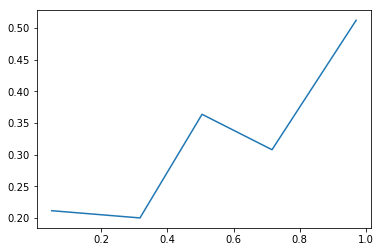

In [133]:
# http://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, n_bins=5)
plot(mean_predicted_value, fraction_of_positives)

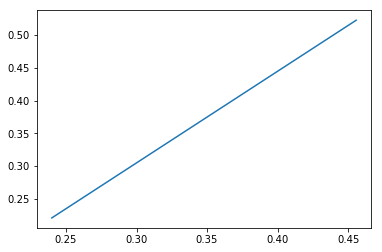

In [129]:
clf = LogisticRegression(C=1., solver='lbfgs')

y_true = np.asarray(y_true)
X = y_pred[:,None]
clf.fit(X, y_true)
y_cal = clf.predict_proba(X)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_cal, n_bins=5)
plot(mean_predicted_value, fraction_of_positives)

In [127]:
sklearn.metrics.log_loss(y_true, y_cal)

0.56941491184575588